In [16]:
import torch
import pickle
import os,sys
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sys.path.append("../../../")
sys.path.append("../../")

from human_aware_rl.rllib.utils import get_base_ae
from human_aware_rl.dummy.rl_agent import *
from overcooked_ai_py.agents.agent import AgentPair

In [17]:
def load_checkpoint(file_path):
    assert os.path.isfile(file_path)
    with open(file_path, 'rb') as file:
        checkpoint = pickle.load(file)
    return checkpoint["reward_model"], checkpoint['config'], checkpoint['expert_svf']

def reset_dummy_policy(policy):
    if isinstance(policy, DummyPolicy) and hasattr(policy, 'reset'):
        policy.reset()
        
def getVisitation(states, joint_action, env):
    target_player_idx = 0
    num_game = len(states)
    freq = {}
    for game, actions in zip(states,joint_action):
        for s,a in zip(game,actions):
            reward_features = env.human_coop_state_encoding(s, a, 0)[target_player_idx]
            reward_features = tuple(reward_features)
            if reward_features not in freq:
                freq[reward_features] = 0
            freq[reward_features] += 1
    
    for state in freq:
        freq[state] /= num_game
    return freq

def getExpertStateFeatures(train_config, left_agent, right_agent):
    mdp_params = train_config["environment_params"]["mdp_params"]
    env_params = train_config["environment_params"]["env_params"]
    ae = get_base_ae(mdp_params, env_params)
    env = ae.env


    agent_pair = AgentPair(left_agent, right_agent)
    results = env.get_rollouts(agent_pair=agent_pair, num_games=1, display=False)
    states = results['ep_states']
    actions = results['ep_actions']

    act = []
    for idx in actions[0]:
        act.append([Action.ACTION_TO_INDEX[idx[0]], Action.ACTION_TO_INDEX[idx[1]]])
    actions = act
    states = states[0]

    target_player_idx = 0
    features = []    
    for s,a in zip(states,actions):
        reward_features = env.human_coop_state_encoding(s, a, 0)[target_player_idx]
        features.append(reward_features)
    return features

def min_max_scale(a, b=None):
    # apply min-max scaling, range becomes [0,1]
    if b is None:
        mini = torch.min(a)
        maxi = torch.max(a)
        a = (a - mini) / (maxi - mini)
        return a
    else:
        mini = min(torch.min(a), torch.min(b))
        maxi = max(torch.max(a), torch.max(b))
        a = (a - mini) / (maxi - mini)
        b = (b - mini) / (maxi - mini)
        return a,b

In [18]:
ltn_ckpt = "/Users/jasmineli/Desktop/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/best-models/T2_ltn_epoch=20.checkpoint"
wte_ckpt = "/Users/jasmineli/Desktop/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/best-models/T2_wte_epoch=30.checkpoint"
coop_ckpt = "/Users/jasmineli/Desktop/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/best-models/T27_coop_epoch=35.checkpoint"
noncoop_ckpt = "/Users/jasmineli/Desktop/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/best-models/T27_noncoop_epoch=20.checkpoint"

ltn_reward_model, ltn_config, ltn_state_visit = load_checkpoint(ltn_ckpt)
wte_reward_model, wte_config, wte_state_visit = load_checkpoint(wte_ckpt)
cp_reward_model, cp_config, cp_state_visit = load_checkpoint(coop_ckpt)
ncp_reward_model, ncp_config, ncp_state_visit = load_checkpoint(noncoop_ckpt)

In [19]:
COOP_BOT_SVF = getExpertStateFeatures(cp_config, MAICooperativeAgent(), MAIDummyRightCoopAgent())
NONCOOP_BOT_SVF = getExpertStateFeatures(ncp_config, MAINonCoopAgent(), MAIDummyRightCoopAgent())

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 5.00; : 100%|██████████| 1/1 [00:00<00:00, 62.73it/s]


Skipping trajectory consistency checking because MDP was recognized as variable. Trajectory consistency checking is not yet supported for variable MDPs.


Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 8.00; : 100%|██████████| 1/1 [00:00<00:00, 221.49it/s]

Skipping trajectory consistency checking because MDP was recognized as variable. Trajectory consistency checking is not yet supported for variable MDPs.


In [20]:

def get_stats(reward_model, states):
    lst = []
    for state in states:
        reward = reward_model.get_rewards(state)
        lst.append(reward[0].item())
    lst = torch.tensor(lst)
    return lst

ltn_cp = get_stats(ltn_reward_model, COOP_BOT_SVF)[:5]
ltn_np = get_stats(ltn_reward_model, NONCOOP_BOT_SVF)

wte_cp = get_stats(wte_reward_model, COOP_BOT_SVF)[:5]
wte_np = get_stats(wte_reward_model, NONCOOP_BOT_SVF)

cp_cp = get_stats(cp_reward_model, COOP_BOT_SVF)[:5]
cp_np = get_stats(cp_reward_model, NONCOOP_BOT_SVF)

ncp_cp = get_stats(ncp_reward_model, COOP_BOT_SVF)[:5]
ncp_np = get_stats(ncp_reward_model, NONCOOP_BOT_SVF)

In [21]:
def min_max_scale_with_avg(a, b):
    # apply min-max scaling, range becomes [0,1]
    mini = min(torch.min(a), torch.min(b))
    maxi = max(torch.max(a), torch.max(b))
    a = torch.sum((a - mini) / (maxi - mini)) / len(a)
    b = torch.sum((b - mini) / (maxi - mini)) / len(b)
    return a,b

# scaled average reward per step
avg_ltn_cp, avg_ltn_np = min_max_scale_with_avg(ltn_cp, ltn_np)
avg_wte_cp, avg_wte_np = min_max_scale_with_avg(wte_cp, wte_np)
avg_coop_cp, avg_coop_np = min_max_scale_with_avg(cp_cp, cp_np)
avg_noncoop_cp, avg_noncoop_np = min_max_scale_with_avg(ncp_cp, ncp_np)

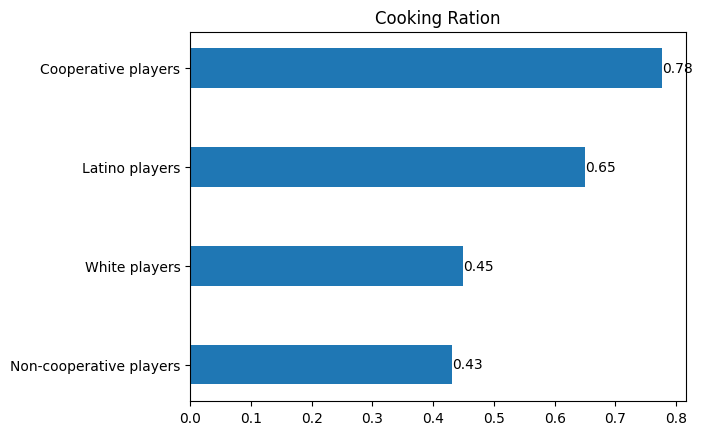

In [22]:
width = 0.2
ratio = [avg_noncoop_cp / avg_noncoop_np, avg_wte_cp / avg_wte_np, avg_ltn_cp / avg_ltn_np, avg_coop_cp / avg_coop_np]
ind = 0.5 * np.arange(4)
label = ['Non-cooperative players', 'White players','Latino players', 'Cooperative players']

fig, ax = plt.subplots()
bar = ax.barh(ind + 0.5 * width, ratio, width) #, color=['olive', 'peru'])

ratio = ["{:.2f}".format(round(r.item(), 2)) for r in ratio]
plt.bar_label(bar, ratio)

# ax.barh(ind, [coop_noncoop], width, color='olive', label='non-cooperative reward')

ax.set(yticks=ind + 0.5*width, yticklabels=label) #, ylim=[width - 0.6, 1.1])
ax.set_title('Cooking Ration')
plt.show()

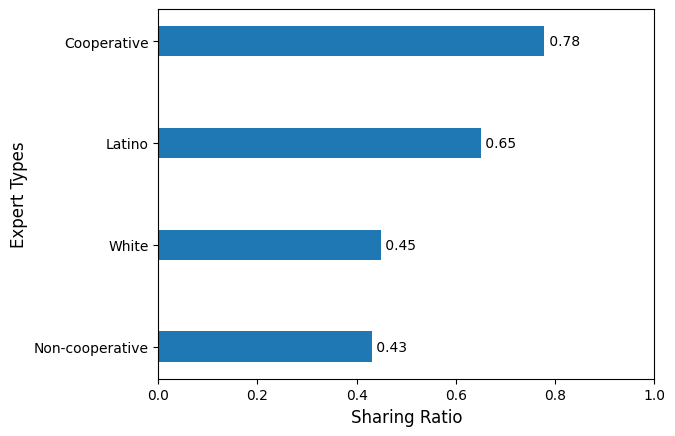

In [35]:
# Data
labels = ['Non-cooperative', 'White', 'Latino', 'Cooperative']
values = [avg_noncoop_cp / avg_noncoop_np, avg_wte_cp / avg_wte_np, avg_ltn_cp / avg_ltn_np, avg_coop_cp / avg_coop_np]

# Create a horizontal bar graph with thinner bars
plt.barh(labels, values, height=0.3) # , color='white', edgecolor='black')  # You can adjust the height as needed

# Set the x-axis limits to start from 0
plt.xlim(0, 1)

# Add labels and a title
plt.xlabel('Sharing Ratio', fontsize=12)
plt.ylabel('Expert Types', fontsize=12)

# Label each bar with its values
bar_values = [round(v.item(), 2) for v in values]
for i, v in enumerate(bar_values):
    plt.text(v, i, f' {v}', va='center', fontsize=10)

# Display the graph
# plt.show()
plt.savefig('/Users/jasmineli/Downloads/sharing-ratio.pdf', bbox_inches='tight')


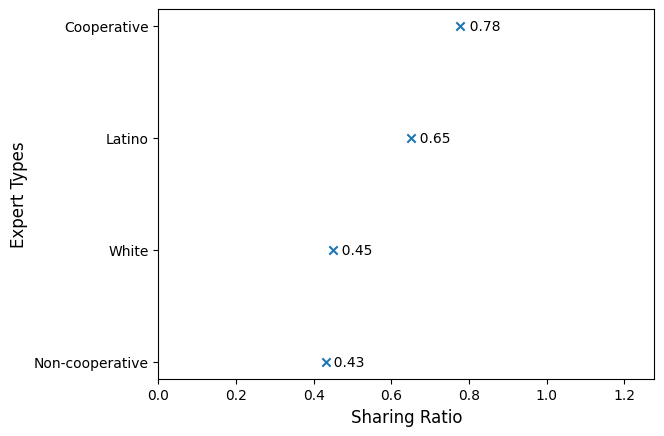

In [24]:

# Create figure and axes
fig, ax = plt.subplots()

# Calculate the y-positions for the scatter points
y = np.arange(len(values))

# Create the horizontal scatter plot
ax.scatter(values, y, marker='x')

# Label each dot with its value
for i, value in enumerate(bar_values):
    ax.text(value, y[i], f'  {value}', va='center', fontsize=10)

# Set x-axis range
plt.xlim(0, max(values) + 0.5)

# Set x-axis label
plt.xlabel('Sharing Ratio', fontsize=12)
plt.ylabel('Expert Types', fontsize=12)

# Set y-axis labels
ax.set_yticks(y)
ax.set_yticklabels(labels)

# Display the graph
plt.show()

# Plotting reward per feature

In [25]:
FEATURES = [
    'p0 onion dx', 'p0 onion dy', 
    'p0 bridge dx', 'p0 bridge dy', 
    'p0 stove dx', 'p0 stove dy', 
    'p0 orientation(N)', 'p0 orientation(S)', 'p0 orientation(E)', 'p0 orientation(W)',  
    'left agent\nhas onion', 
    'right agent\nhas onion',
    'onion\non bridge',
    'onion\nin pot',
    'p0 at (4,3) w/ onion',
    'p0 at (4,2) w/ onion',
    'p0 at (4,1) w/ onion',
    'p0 at (3,1) w/ onion',
    ]

feat = torch.diag(torch.ones(18))

ltn_rew_per_feat = ltn_reward_model.get_rewards(feat).squeeze()
wte_rew_per_feat = wte_reward_model.get_rewards(feat).squeeze()
ncp_reward_per_feat = ncp_reward_model.get_rewards(feat).squeeze()
cp_reward_per_feat = cp_reward_model.get_rewards(feat).squeeze()

ltn_rew_per_feat = min_max_scale(ltn_rew_per_feat)
wte_rew_per_feat = min_max_scale(wte_rew_per_feat)
ncp_reward_per_feat = min_max_scale(ncp_reward_per_feat)
cp_reward_per_feat = min_max_scale(cp_reward_per_feat)

for rew in [ltn_rew_per_feat, wte_rew_per_feat, ncp_reward_per_feat, cp_reward_per_feat]:   
    for i in range(4):
        rew[i] = -1 * rew[i]


In [26]:
import numpy as np 

def plot_bar(rewards1, rewards2, features, title):
    bar_labels_1 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards1]
    bar_labels_2 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards2]
    plt.clf()

    plt.figure() 

    n = len(features)
    r = np.arange(n)
    height = 0.5

    bar_1 = plt.barh(r * 4 * height, rewards1, label="latino", height=0.4)
    bar_2 = plt.barh(r * 4 * height + height, rewards2, label="white", height=0.4)
    plt.xlim([-0.5, 1.2])
    plt.bar_label(bar_1, bar_labels_1)
    plt.bar_label(bar_2, bar_labels_2)

    plt.yticks(r * 4 * height + 1.5 * height, features)
    plt.legend()
    plt.title(title)
    # plt.plot()
    plt.show
    # plt.savefig('t20_human_reward_comparison.pdf', format='pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

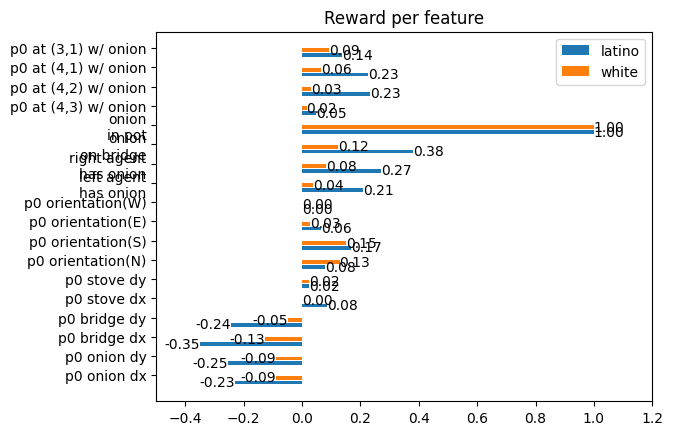

In [27]:
plot_bar(ltn_rew_per_feat, wte_rew_per_feat, FEATURES, "Reward per feature")

<Figure size 640x480 with 0 Axes>

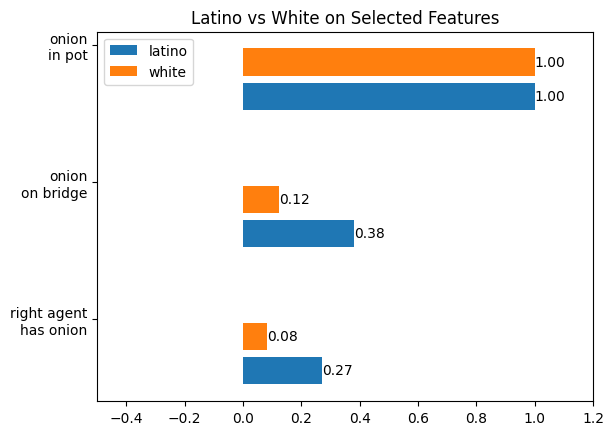

In [28]:
selected_feat_idx = [11, 12, 13]
feature_label = [FEATURES[i] for i in selected_feat_idx]
latino = [ltn_rew_per_feat[i] for i in selected_feat_idx]
white = [wte_rew_per_feat[i] for i in selected_feat_idx]

plot_bar(latino, white, feature_label, "Latino vs White on Selected Features")



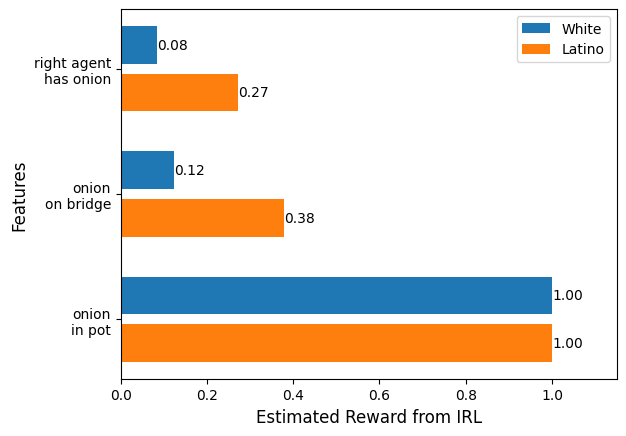

In [34]:
bar_width = 0.3  # Width of each bar
bar_gap = 0.08  # Gap between pairs of bars

# Create figure and axes
fig, ax = plt.subplots()

# Calculate the x-positions for each set of bars
x = np.arange(len(feature_label))

# Create the bars for "white" data
white_bars = ax.barh(x - (bar_width + bar_gap) / 2, white, bar_width, label='White') # , color='white', edgecolor='black', hatch='//')

# Create the bars for "latino" data
latino_bars = ax.barh(x + (bar_width + bar_gap) / 2, latino, bar_width, label='Latino') #, color='white', edgecolor='black')

# Add labels and a title
ax.set_xlabel('Estimated Reward from IRL', fontsize=12)
ax.set_ylabel('Features', fontsize=12)

# Label each bar with its numeric value for "white" data
for bar, value in zip(white_bars, white):
    ax.text(value, bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', fontsize=10)

# Label each bar with its numeric value for "latino" data
for bar, value in zip(latino_bars, latino):
    ax.text(value, bar.get_y() + bar.get_height() / 2, f'{value:.2f}', va='center', fontsize=10)

# Set ytick labels
ax.set_yticks(x)
ax.set_yticklabels(feature_label)

# Add a legend
ax.legend(loc='upper right')

# Set the x-axis limits to start from 0
plt.xlim(0, 1.15)

# Invert the y-axis to display the bars from top to bottom
ax.invert_yaxis()

# Display the graph
# plt.show()
plt.savefig('/Users/jasmineli/Downloads/selected-features.pdf', bbox_inches='tight')

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (3).

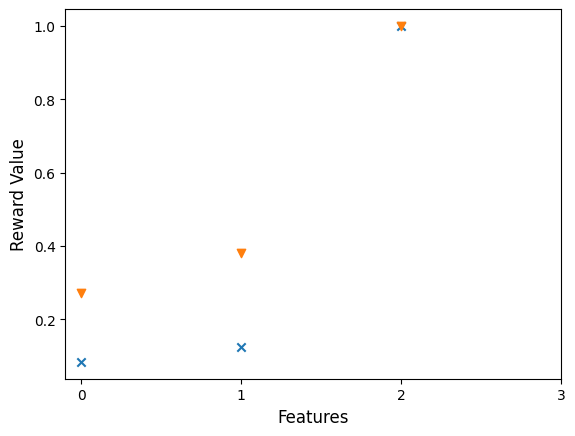

In [30]:
# Create figure and axes
fig, ax = plt.subplots()

# Calculate the y-positions for the scatter points
y = np.arange(len(labels))

# Define the vertical separation between pairs
horizontal_spacing = 0.0

# Create the vertical scatter plot for "white" data
scatter_white = ax.scatter(x - horizontal_spacing, white, label='White', marker='x')

# Create the vertical scatter plot for "latino" data
scatter_latino = ax.scatter(x + horizontal_spacing, latino, label='Latino', marker='v')

# Add labels and a title
ax.set_ylabel('Reward Value', fontsize=12)
ax.set_xlabel('Features', fontsize=12)

# Set y-axis labels
ax.set_xticks(y)
ax.set_xticklabels(feature_label)

# Set x-axis range
ax.set_ylim(0, 1.10)

# Add a legend
ax.legend(loc='lower right')

# Label each scatter point with its value for "white" data
for i, value in enumerate(white):
    ax.text(y[i] - horizontal_spacing, value + 0.02, f'  {value:.2f}', ha='center', fontsize=10)

# Label each scatter point with its value for "latino" data
for i, value in enumerate(latino[:-1]):
    ax.text(y[i] + horizontal_spacing, value + 0.02, f'{value:.2f}', ha='center', fontsize=10)

# Display the graph
plt.show()